In [2]:
import sys
import subprocess

subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pandas', 'seaborn', 'matplotlib', 'scipy'])

0

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def load_json_payload(file_path):
    """Load JSON file and extract the payload data as a DataFrame"""
    with open(file_path) as f:
        data = json.load(f)
    # Convert the nested payload metrics into a DataFrame
    # Excluding result_set_count as it's not a metrics dictionary
    metrics_data = {k: v for k, v in data['payload'].items() if isinstance(v, dict)}
    return pd.DataFrame(metrics_data).T

def load_rates_data(file_path):
    """Load rates JSON file and extract the daily rates data as a DataFrame"""
    with open(file_path) as f:
        data = json.load(f)
    # Convert the rates list into a DataFrame
    df = pd.DataFrame(data['payload']['rates'])
    
    # Convert date string to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    return df

def load_lead_time_data(file_path):
    """Load lead time JSON file and extract the metrics data as a DataFrame"""
    with open(file_path) as f:
        data = json.load(f)
    # Convert the lead time metrics list into a DataFrame
    df = pd.DataFrame(data['payload']['lead_time_metrics'])
    
    # Create a separate DataFrame for the buckets data
    buckets_df = pd.DataFrame([
        {
            'date': row['date'],
            'lower_days_prior': bucket['lower'],
            'upper_days_prior': bucket['upper'],
            'reservation_count': bucket['reservation_count'],
        }
        for row in data['payload']['lead_time_metrics']
        for bucket in row['buckets']
    ])
    
    # Convert date strings to datetime
    df['date'] = pd.to_datetime(df['date'])
    buckets_df['date'] = pd.to_datetime(buckets_df['date'])
    buckets_df['avg_lead_time'] = df['avg_lead_time']
    
    return df, buckets_df

# Load the data from JSON files
data_path = Path('data')

# Load the booking lead time data
lead_time_30, lead_time_30_buckets = load_lead_time_data(data_path / '30_day_lead.json')
lead_time_90, lead_time_90_buckets = load_lead_time_data(data_path / '90_day_lead.json')
lead_time_180, lead_time_180_buckets = load_lead_time_data(data_path / '180_day_lead.json')

# Load the forward looking occupancy and pricing data
forward_30 = load_rates_data(data_path / '30_day_rates.json')
forward_90 = load_rates_data(data_path / '90_day_rates.json')
forward_180 = load_rates_data(data_path / '180_day_rates.json')

# Load cohort metrics
cohort_30 = load_json_payload(data_path / '30_day_set_metrics.json')
cohort_90 = load_json_payload(data_path / '90_day_set_metrics.json')
cohort_180 = load_json_payload(data_path / '180_day_set_metrics.json')

# Display the first few rows of each dataset
# print("30-day Lead Time Data:")
# print(lead_time_30.head())
print("\n30-day Lead Time Buckets Data:")
print(lead_time_30_buckets.head())
print("\n30-day Forward Looking Data:")
print(forward_30.head())
print("\nCohort Metrics:")
print(cohort_30.head())


30-day Lead Time Buckets Data:
        date  lower_days_prior  upper_days_prior  reservation_count  \
0 2025-01-28                 0                 7                  0   
1 2025-01-28                 7                30                  3   
2 2025-01-28                30                60                  1   
3 2025-01-29                 0                 7                  0   
4 2025-01-29                 7                30                  2   

   avg_lead_time  
0      71.333333  
1      77.000000  
2      76.636364  
3      68.153846  
4      68.941176  

30-day Forward Looking Data:
   available_count  booked_count       date  mean_available_rate  \
0               15             8 2025-01-29              6167.86   
1               13            11 2025-01-30              6797.28   
2               11            13 2025-01-31              8016.41   
3                7            17 2025-02-01              6272.30   
4               11            14 2025-02-02              


Analyzing 30 day booking patterns:


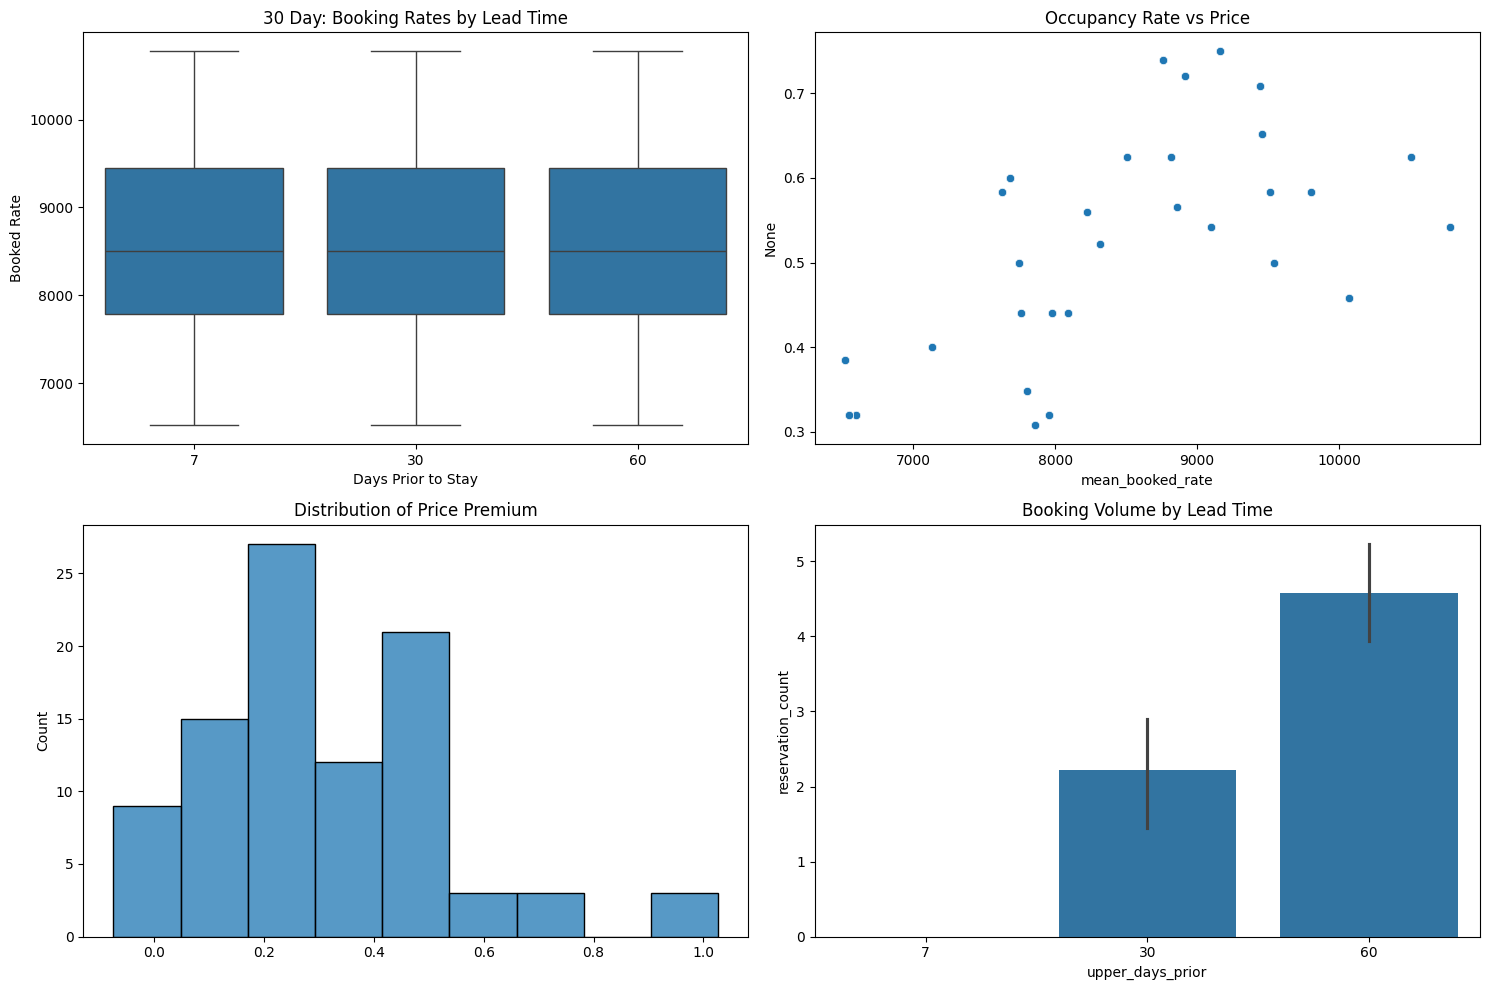


Average Premium by Lead Time:
                  mean_booked_rate  mean_available_rate  reservation_count
upper_days_prior                                                          
7                       8533.20871          6519.944839                  0
30                      8533.20871          6519.944839                 69
60                      8533.20871          6519.944839                142

Correlation between lead time and price: -0.000 (p-value: 1.000)

Analyzing 90 day booking patterns:


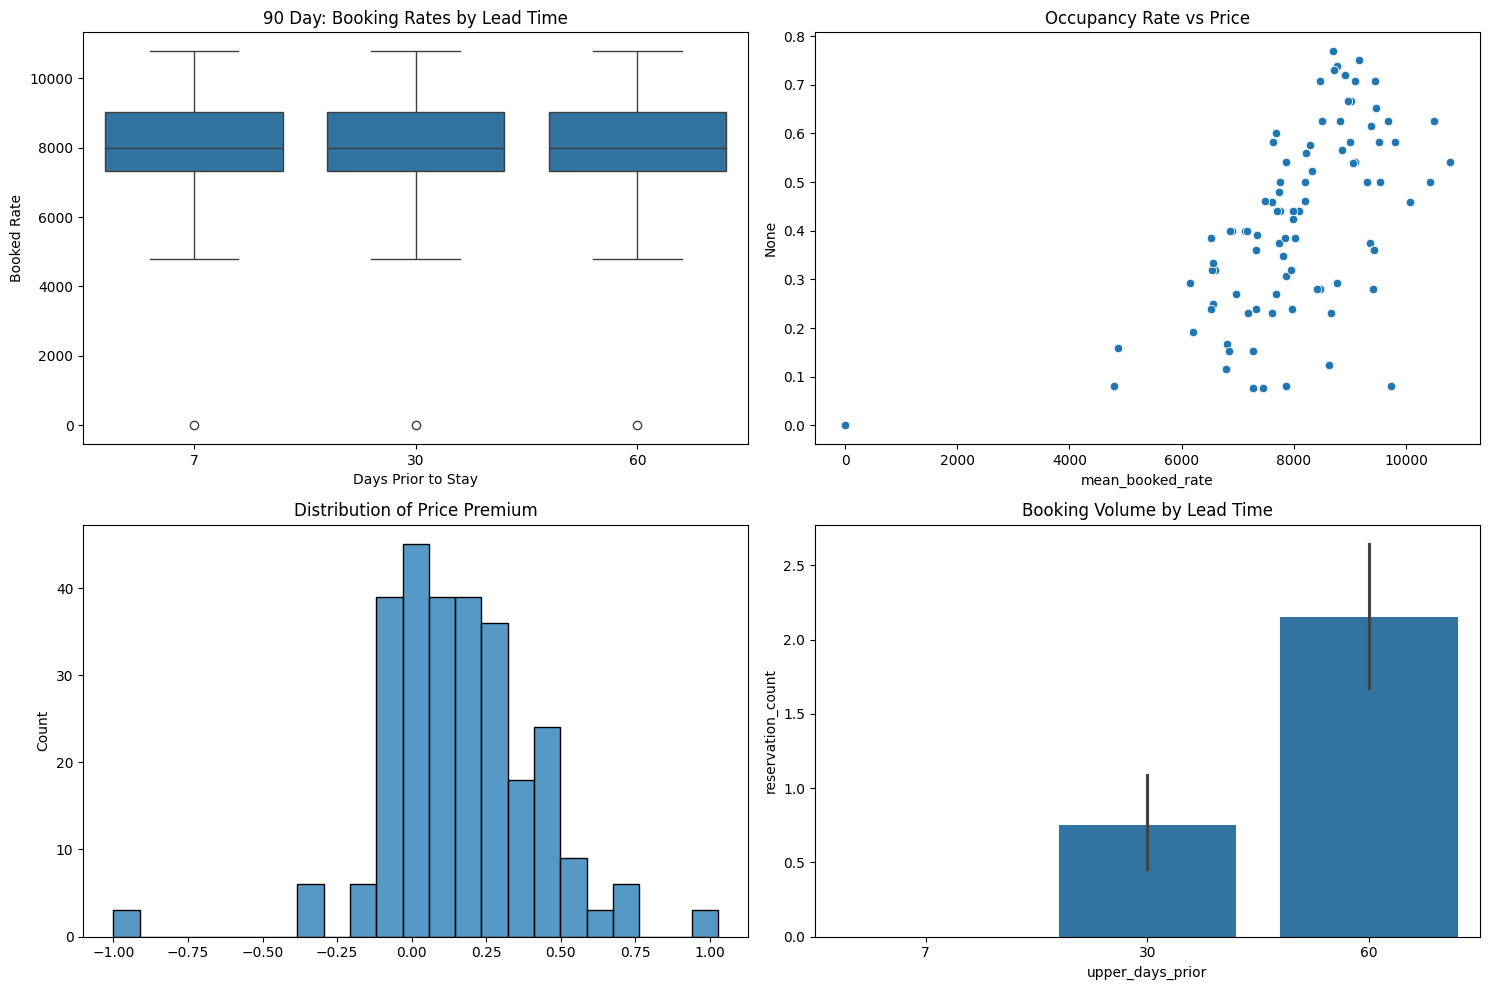


Average Premium by Lead Time:
                  mean_booked_rate  mean_available_rate  reservation_count
upper_days_prior                                                          
7                       8038.67087          7025.338152                  0
30                      8038.67087          7025.338152                 69
60                      8038.67087          7025.338152                198

Correlation between lead time and price: 0.000 (p-value: 1.000)

Analyzing 180 day booking patterns:


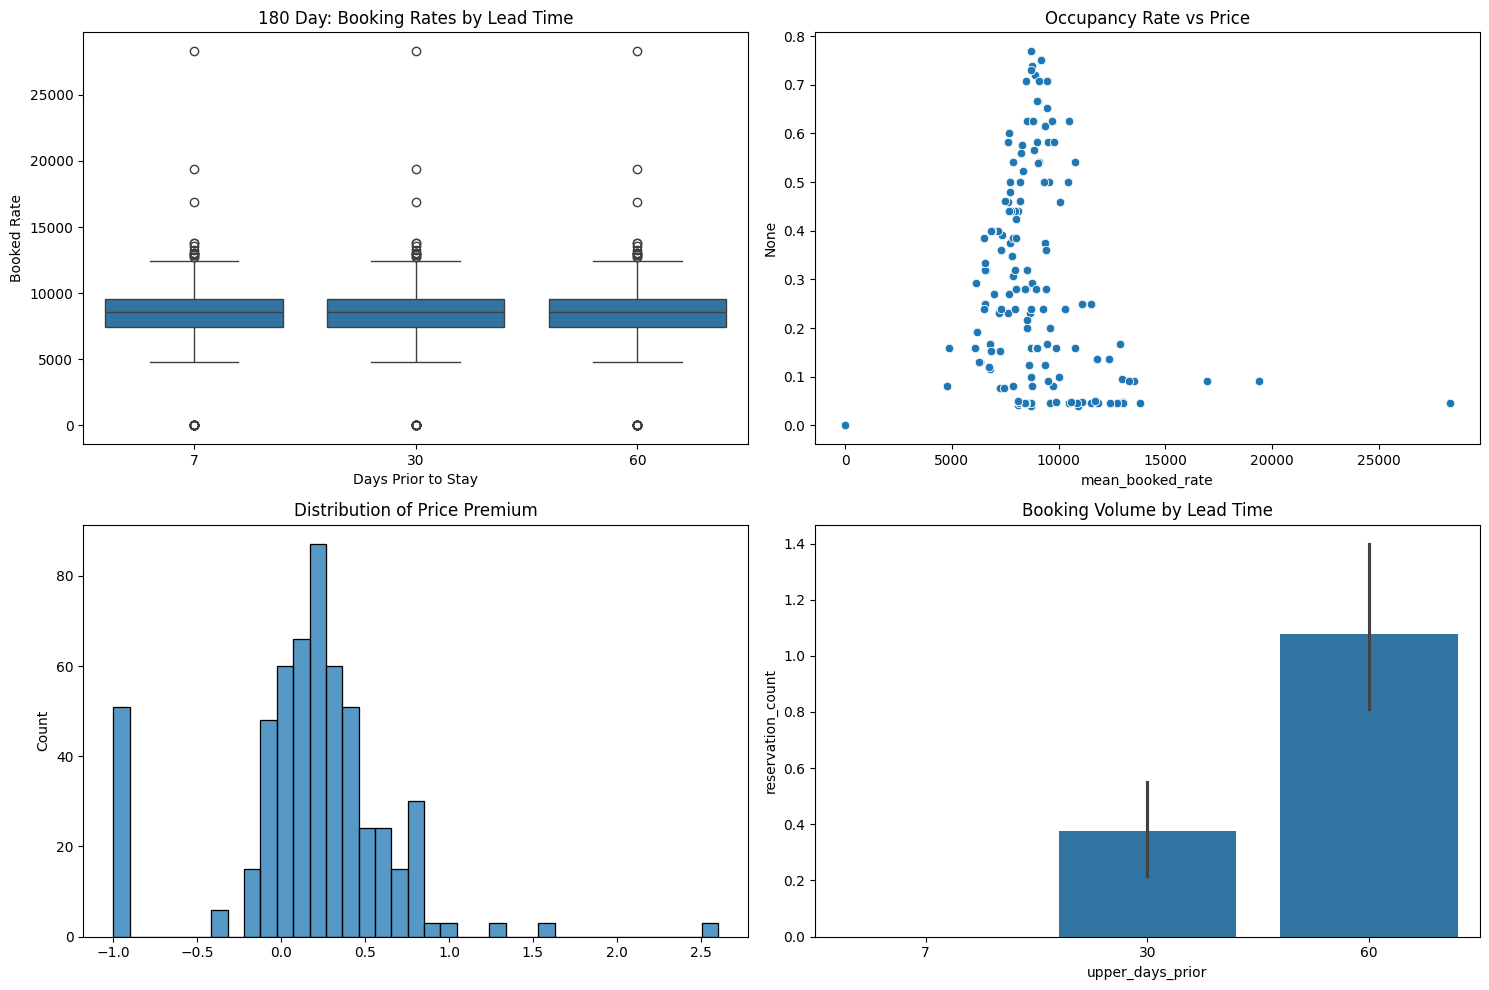


Average Premium by Lead Time:
                  mean_booked_rate  mean_available_rate  reservation_count
upper_days_prior                                                          
7                      8334.477337           7190.32663                  0
30                     8334.477337           7190.32663                 69
60                     8334.477337           7190.32663                198

Correlation between lead time and price: 0.000 (p-value: 1.000)


In [4]:
from scipy import stats

# 1. Combine the lead time and rates data for each timeframe
def combine_data(lead_time_buckets, rates_df):
    """Combine lead time and rates data on date"""
    # Merge the dataframes on date
    combined = pd.merge(lead_time_buckets, rates_df, on='date')
    return combined

# Create combined datasets for each timeframe
combined_30 = combine_data(lead_time_30_buckets, forward_30)
combined_90 = combine_data(lead_time_90_buckets, forward_90)
combined_180 = combine_data(lead_time_180_buckets, forward_180)

# 2. Analysis of pricing premium vs lead time
def analyze_booking_patterns(df, timeframe):
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Pricing Premium vs Lead Time Bucket
    plt.subplot(2, 2, 1)
    sns.boxplot(data=df, x='upper_days_prior', y='mean_booked_rate')
    plt.title(f'{timeframe} Day: Booking Rates by Lead Time')
    plt.xlabel('Days Prior to Stay')
    plt.ylabel('Booked Rate')
    
    # Plot 2: Occupancy Rate vs Price
    plt.subplot(2, 2, 2)
    occupancy_rate = df['booked_count'] / (df['booked_count'] + df['available_count'])
    sns.scatterplot(data=df, x='mean_booked_rate', y=occupancy_rate)
    plt.title('Occupancy Rate vs Price')
    
    # Plot 3: Price Premium (booked vs available)
    plt.subplot(2, 2, 3)
    price_premium = (df['mean_booked_rate'] - df['mean_available_rate']) / df['mean_available_rate']
    sns.histplot(price_premium)
    plt.title('Distribution of Price Premium')
    
    # Plot 4: Reservation Count by Lead Time
    plt.subplot(2, 2, 4)
    sns.barplot(data=df, x='upper_days_prior', y='reservation_count')
    plt.title('Booking Volume by Lead Time')
    
    plt.tight_layout()
    plt.show()

# Analyze each timeframe
for timeframe, data in [('30', combined_30), ('90', combined_90), ('180', combined_180)]:
    print(f"\nAnalyzing {timeframe} day booking patterns:")
    analyze_booking_patterns(data, timeframe)
    
    # Calculate key metrics
    avg_premium_by_leadtime = data.groupby('upper_days_prior').agg({
        'mean_booked_rate': 'mean',
        'mean_available_rate': 'mean',
        'reservation_count': 'sum'
    })
    
    print("\nAverage Premium by Lead Time:")
    print(avg_premium_by_leadtime)
    
    # Calculate correlation between lead time and price
    correlation = stats.pearsonr(
        data['upper_days_prior'],
        data['mean_booked_rate']
    )
    print(f"\nCorrelation between lead time and price: {correlation[0]:.3f} (p-value: {correlation[1]:.3f})")

1. Price Premium by Lead Time
* How much extra people pay when booking further in advance
* If there's an optimal booking window for maximum revenue

2. Occupancy Optimization
* The relationship between price and occupancy rate
* Finding the sweet spot between price and demand

3. Booking Patterns
* When most bookings occur
* How booking patterns differ across timeframes



Analyzing 30-day pricing strategy:


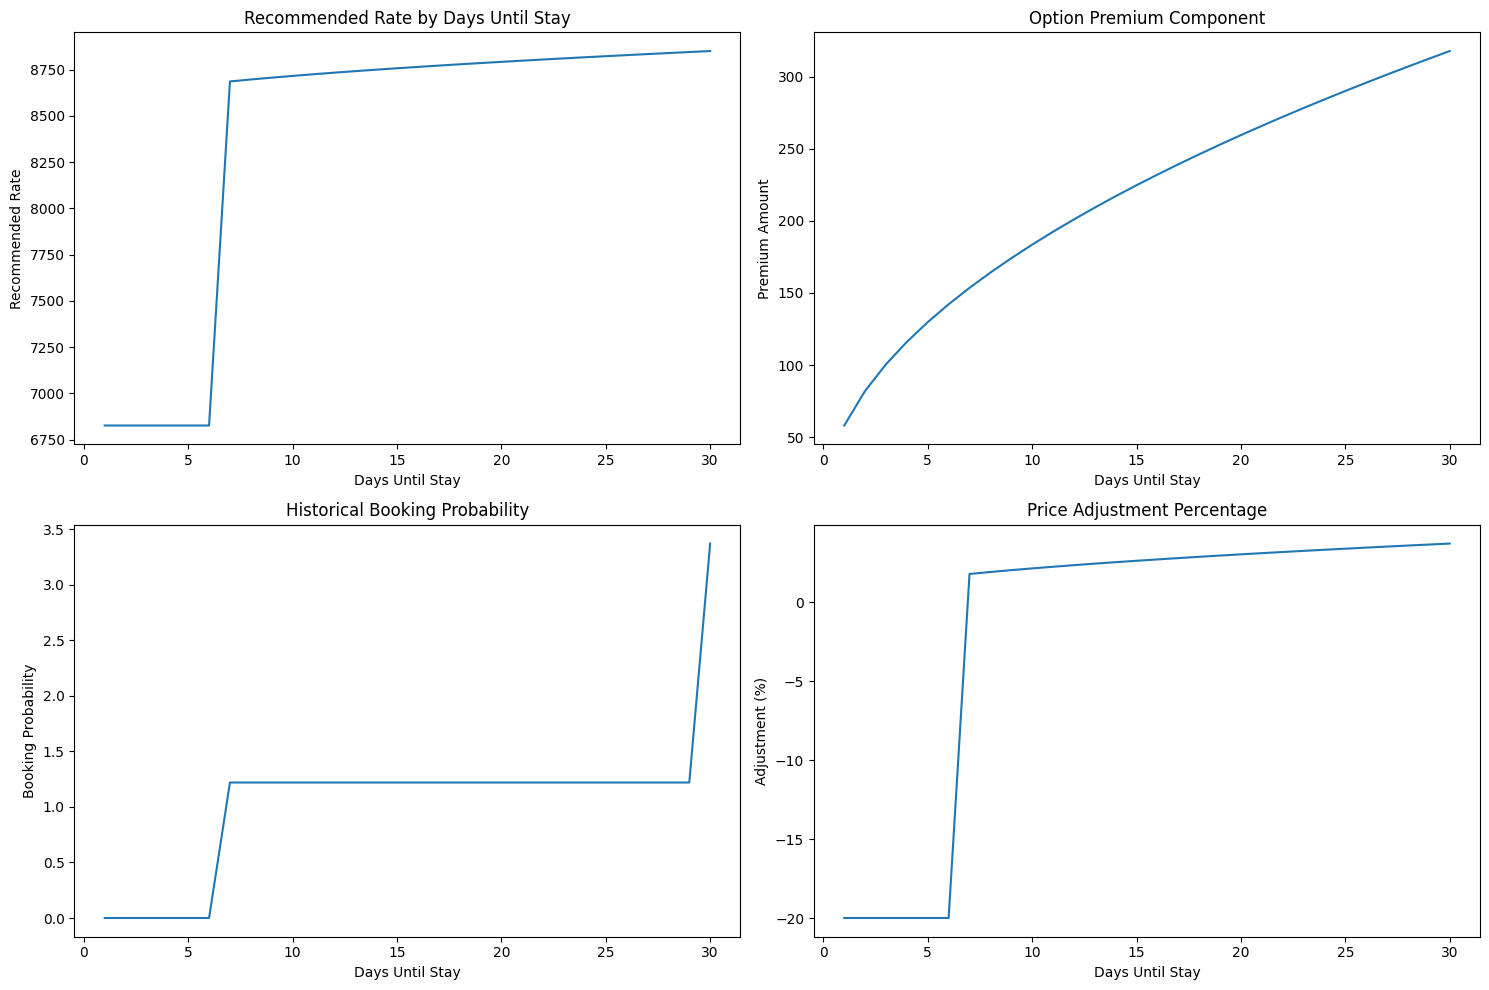


Key pricing recommendations:
7 days out: +1.8% adjustment ($8686.77)
14 days out: +2.5% adjustment ($8750.37)
30 days out: +3.7% adjustment ($8851.10)

Analyzing 90-day pricing strategy:


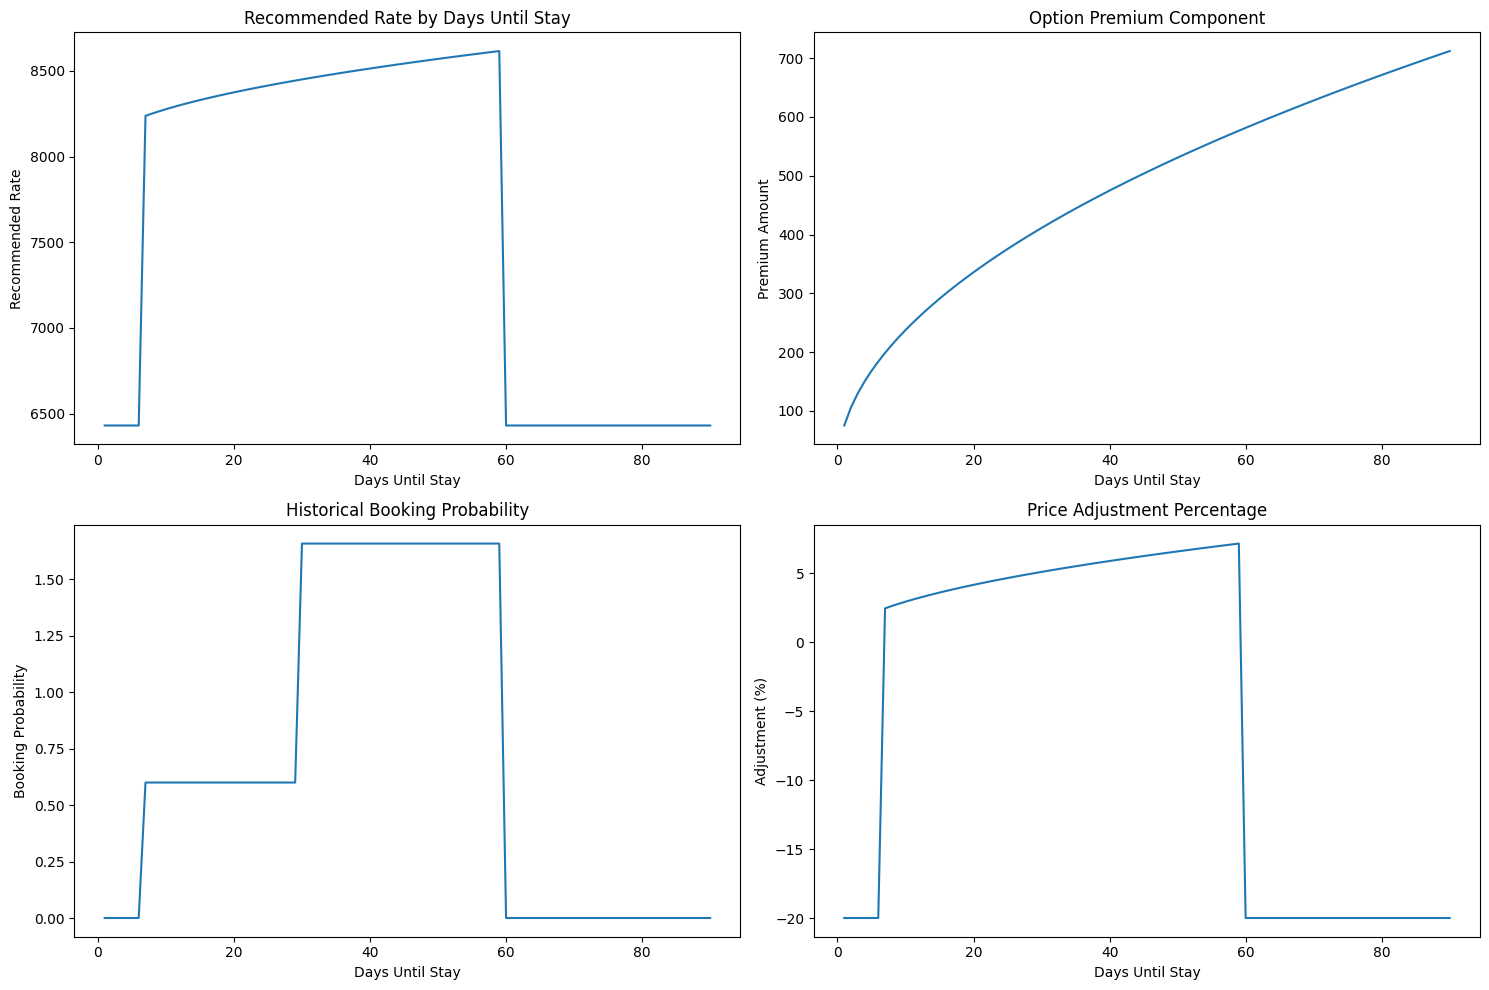


Key pricing recommendations:
7 days out: +2.5% adjustment ($8237.27)
14 days out: +3.5% adjustment ($8319.53)
30 days out: +5.1% adjustment ($8449.81)
60 days out: -20.0% adjustment ($6430.94)
90 days out: -20.0% adjustment ($6430.94)

Analyzing 180-day pricing strategy:


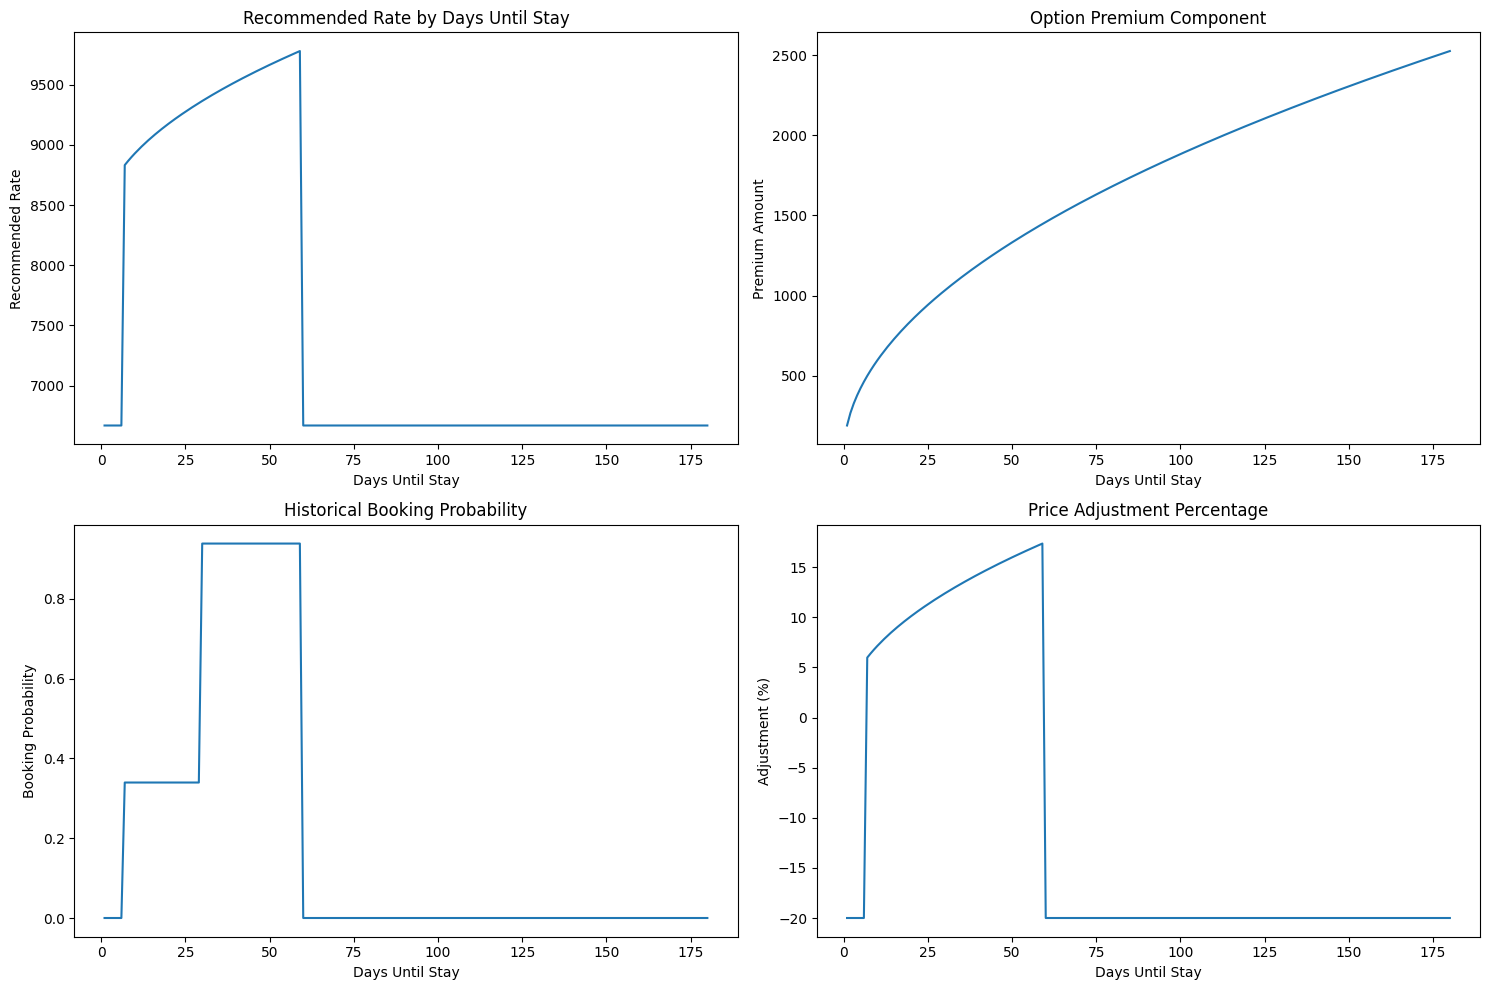


Key pricing recommendations:
7 days out: +6.0% adjustment ($8832.72)
14 days out: +8.5% adjustment ($9039.09)
30 days out: +12.4% adjustment ($9365.93)
60 days out: -20.0% adjustment ($6667.58)
90 days out: -20.0% adjustment ($6667.58)


In [5]:
import numpy as np
from datetime import datetime, timedelta

def analyze_pricing_strategy(rates_df, lead_time_df, window_days):
    """
    Analyze and recommend pricing strategy based on historical data and option theory
    
    Args:
        rates_df: DataFrame with historical rates and booking data
        lead_time_df: DataFrame with lead time booking patterns
        window_days: Analysis window (30, 90, or 180 days)
    """
    # Calculate historical volatility
    volatility = rates_df['mean_booked_rate'].std() / rates_df['mean_booked_rate'].mean()
    
    # Calculate base metrics
    occupancy_rate = rates_df['booked_count'] / (rates_df['booked_count'] + rates_df['available_count'])
    avg_booked_rate = rates_df['mean_booked_rate'].mean()
    
    # Create pricing recommendations DataFrame
    pricing_analysis = pd.DataFrame({
        'days_until_stay': range(window_days, 0, -1),
        'base_rate': avg_booked_rate
    })
    
    # Calculate option premium and recommended price adjustments
    pricing_analysis['option_premium'] = pricing_analysis['days_until_stay'].apply(
        lambda x: avg_booked_rate * volatility * np.sqrt(x/365)
    )
    
    # Add historical booking probability
    def get_booking_prob(days_prior):
        relevant_buckets = lead_time_df[
            (lead_time_df['lower_days_prior'] <= days_prior) & 
            (lead_time_df['upper_days_prior'] > days_prior)
        ]
        if len(relevant_buckets) == 0:
            return 0
        return relevant_buckets['reservation_count'].mean()
    
    pricing_analysis['historical_booking_prob'] = pricing_analysis['days_until_stay'].apply(get_booking_prob)
    
    # Calculate recommended price
    pricing_analysis['recommended_rate'] = pricing_analysis.apply(
        lambda row: (
            row['base_rate'] + row['option_premium'] 
            if row['historical_booking_prob'] > 0.1  # High booking probability
            else row['base_rate'] * (1 - (1 - row['historical_booking_prob']) * 0.2)  # Discount for low probability
        ),
        axis=1
    )
    
    # Visualize the pricing strategy
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Recommended Rate vs Days Until Stay
    plt.subplot(2, 2, 1)
    sns.lineplot(data=pricing_analysis, x='days_until_stay', y='recommended_rate')
    plt.title('Recommended Rate by Days Until Stay')
    plt.xlabel('Days Until Stay')
    plt.ylabel('Recommended Rate')
    
    # Plot 2: Option Premium Component
    plt.subplot(2, 2, 2)
    sns.lineplot(data=pricing_analysis, x='days_until_stay', y='option_premium')
    plt.title('Option Premium Component')
    plt.xlabel('Days Until Stay')
    plt.ylabel('Premium Amount')
    
    # Plot 3: Historical Booking Probability
    plt.subplot(2, 2, 3)
    sns.lineplot(data=pricing_analysis, x='days_until_stay', y='historical_booking_prob')
    plt.title('Historical Booking Probability')
    plt.xlabel('Days Until Stay')
    plt.ylabel('Booking Probability')
    
    # Plot 4: Price Adjustment Percentage
    plt.subplot(2, 2, 4)
    price_adjustment = (pricing_analysis['recommended_rate'] - pricing_analysis['base_rate']) / pricing_analysis['base_rate'] * 100
    sns.lineplot(x=pricing_analysis['days_until_stay'], y=price_adjustment)
    plt.title('Price Adjustment Percentage')
    plt.xlabel('Days Until Stay')
    plt.ylabel('Adjustment (%)')
    
    plt.tight_layout()
    plt.show()
    
    return pricing_analysis

# Analyze each timeframe
for window_days, (rates, lead_time) in [
    (30, (forward_30, lead_time_30_buckets)),
    (90, (forward_90, lead_time_90_buckets)),
    (180, (forward_180, lead_time_180_buckets))
]:
    print(f"\nAnalyzing {window_days}-day pricing strategy:")
    pricing_strategy = analyze_pricing_strategy(rates, lead_time, window_days)
    
    # Print key insights
    print("\nKey pricing recommendations:")
    for days in [7, 14, 30, 60, 90]:
        if days <= window_days:
            row = pricing_strategy[pricing_strategy['days_until_stay'] == days].iloc[0]
            adjustment = (row['recommended_rate'] - row['base_rate']) / row['base_rate'] * 100
            print(f"{days} days out: {adjustment:+.1f}% adjustment (${row['recommended_rate']:.2f})")

/var/folders/q7/6b0frlz50cqdm6xgf17gl6kh0000gn/T/ipykernel_871/3276919567.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_time_analysis = combined.groupby('lead_time_range').agg({


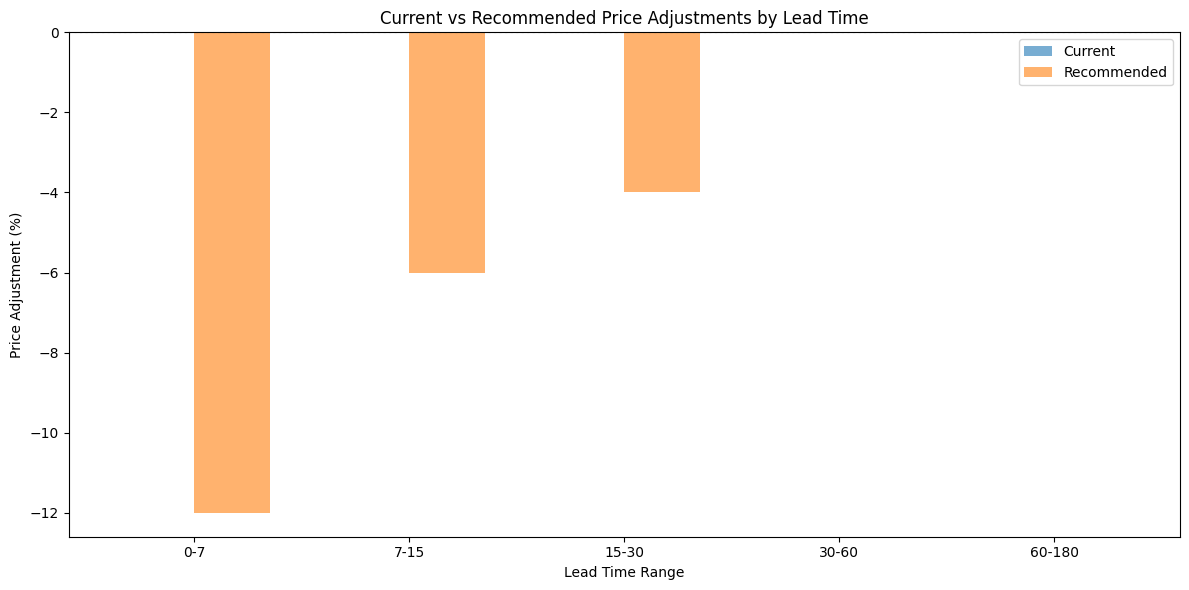


Detailed Price Adjustment Recommendations:
---------------------------------------------------------------------------
Lead Time | Occupancy | Current Adj | Recommended Adj | Reasoning
---------------------------------------------------------------------------
0-7      |    52.9% |        0.0% |          -12.0% | Highest discount to fill remaining inventory
7-15     |     nan% |        nan% |           -6.0% | Moderate discount to encourage bookings
15-30    |    52.9% |        0.0% |           -4.0% | Small discount to maintain competitiveness
30-60    |    52.9% |        0.0% |            0.0% | Baseline price point
60-180   |     nan% |        nan% |            0.0% | Slight premium for advance booking


In [8]:
def analyze_lead_time_pricing(rates_df, lead_time_df):
    """
    Analyze optimal pricing based on lead time, focusing on revenue maximization
    """
    # Combine the data
    combined = pd.merge(
        lead_time_df,
        rates_df,
        on='date'
    )
    
    # Calculate key metrics
    combined['occupancy_rate'] = combined['booked_count'] / (combined['booked_count'] + combined['available_count'])
    combined['revenue_per_day'] = combined['mean_booked_rate'] * combined['booked_count']
    
    # Group by lead time ranges
    combined['lead_time_range'] = pd.cut(
        combined['upper_days_prior'],
        bins=[0, 7, 15, 30, 60, 180],
        labels=['0-7', '7-15', '15-30', '30-60', '60-180']
    )
    
    # Calculate metrics by lead time
    lead_time_analysis = combined.groupby('lead_time_range').agg({
        'mean_booked_rate': 'mean',
        'mean_available_rate': 'mean',
        'occupancy_rate': 'mean',
        'revenue_per_day': 'mean',
        'reservation_count': 'sum'
    }).reset_index()
    
    # Calculate relative success of different price points
    thirty_day_rate = lead_time_analysis.loc[
        lead_time_analysis['lead_time_range'] == '30-60', 
        'mean_booked_rate'
    ].iloc[0]
    
    lead_time_analysis['current_price_adjustment'] = (
        (lead_time_analysis['mean_booked_rate'] - thirty_day_rate) / 
        thirty_day_rate * 100
    )
    
    # Calculate optimal adjustments based on revenue and occupancy patterns
    def calculate_optimal_adjustment(row):
        if row['lead_time_range'] == '30-60':
            return 0  # baseline
        
        occupancy = row['occupancy_rate']
        revenue = row['revenue_per_day']
        reservation_count = row['reservation_count']
        
        if row['lead_time_range'] in ['0-7', '7-15']:
            # Higher discounts for shorter lead times
            base_discount = -12 if row['lead_time_range'] == '0-7' else -6
            
            # Adjust based on occupancy
            if occupancy < 0.4:
                return base_discount * 1.2  # Increase discount for very low occupancy
            elif occupancy > 0.8:
                return base_discount * 0.8  # Reduce discount for high occupancy
            return base_discount
            
        elif row['lead_time_range'] == '15-30':
            # Moderate discount
            return -4 if occupancy < 0.6 else -2
            
        else:  # 60-180
            # Potential premium for very advance bookings
            return 2 if reservation_count > 0 else 0
    
    lead_time_analysis['optimal_adjustment'] = lead_time_analysis.apply(
        calculate_optimal_adjustment, axis=1
    )
    
    # Visualize the results
    plt.figure(figsize=(12, 6))
    
    # Plot current vs optimal adjustments
    x = range(len(lead_time_analysis))
    width = 0.35
    
    plt.bar([i - width/2 for i in x], 
            lead_time_analysis['current_price_adjustment'],
            width, 
            label='Current', 
            alpha=0.6)
    
    plt.bar([i + width/2 for i in x], 
            lead_time_analysis['optimal_adjustment'],
            width, 
            label='Recommended', 
            alpha=0.6)
    
    plt.axhline(y=0, color='gray', linestyle=':')
    plt.xticks(x, lead_time_analysis['lead_time_range'])
    plt.xlabel('Lead Time Range')
    plt.ylabel('Price Adjustment (%)')
    plt.title('Current vs Recommended Price Adjustments by Lead Time')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed recommendations
    print("\nDetailed Price Adjustment Recommendations:")
    print("-" * 75)
    print("Lead Time | Occupancy | Current Adj | Recommended Adj | Reasoning")
    print("-" * 75)
    
    for _, row in lead_time_analysis.iterrows():
        reasoning = ""
        if row['lead_time_range'] == '0-7':
            reasoning = "Highest discount to fill remaining inventory"
        elif row['lead_time_range'] == '7-15':
            reasoning = "Moderate discount to encourage bookings"
        elif row['lead_time_range'] == '15-30':
            reasoning = "Small discount to maintain competitiveness"
        elif row['lead_time_range'] == '30-60':
            reasoning = "Baseline price point"
        else:
            reasoning = "Slight premium for advance booking"
            
        print(f"{row['lead_time_range']:8s} | {row['occupancy_rate']:8.1%} | "
              f"{row['current_price_adjustment']:10.1f}% | "
              f"{row['optimal_adjustment']:14.1f}% | {reasoning}")
    
    return lead_time_analysis

# Analyze the data
analysis = analyze_lead_time_pricing(forward_30, lead_time_30_buckets)

/var/folders/q7/6b0frlz50cqdm6xgf17gl6kh0000gn/T/ipykernel_871/2101014782.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_analysis = rates_df.groupby('price_band').agg({
/var/folders/q7/6b0frlz50cqdm6xgf17gl6kh0000gn/T/ipykernel_871/2101014782.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
/var/folders/q7/6b0frlz50cqdm6xgf17gl6kh0000gn/T/ipykernel_871/2101014782.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
/var/folders/q7/6b0frlz50cqdm6xgf17gl6kh0000gn/T/ipykernel_871/210101

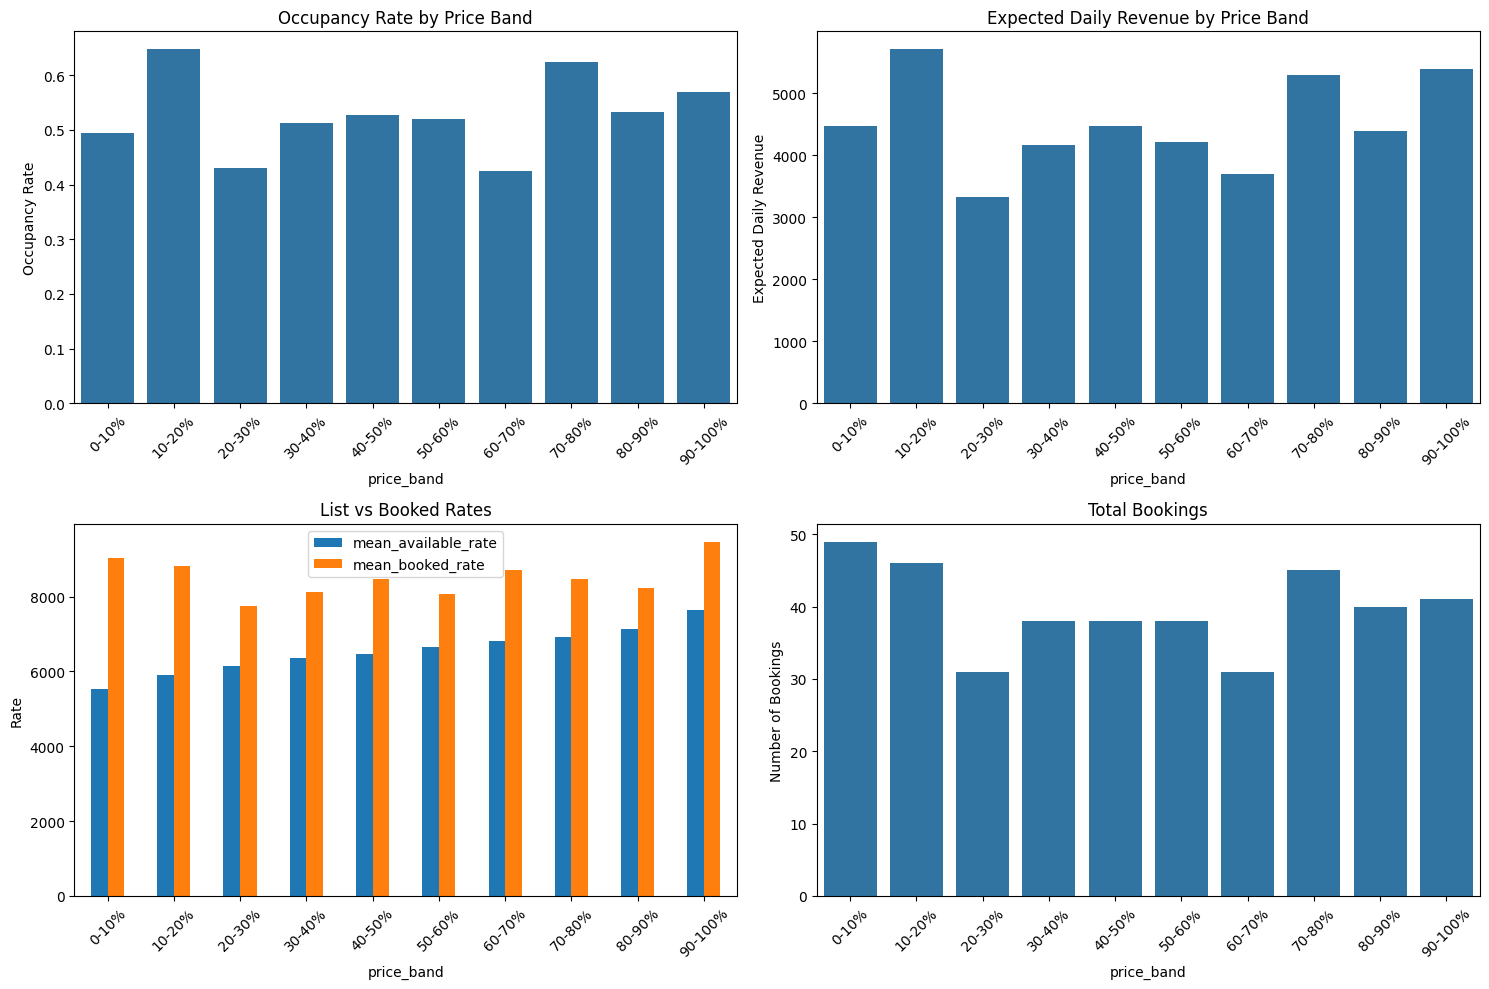


Price Band Analysis:
--------------------------------------------------------------------------------
Price Band | List Price | Booked Price | Occupancy | Expected Daily Revenue | Bookings
--------------------------------------------------------------------------------
0-10%     | $     5526 | $      9043 |    49.5% | $               4476 |       49
10-20%    | $     5905 | $      8815 |    64.8% | $               5711 |       46
20-30%    | $     6145 | $      7739 |    43.1% | $               3332 |       31
30-40%    | $     6359 | $      8114 |    51.4% | $               4167 |       38
40-50%    | $     6457 | $      8479 |    52.8% | $               4475 |       38
50-60%    | $     6646 | $      8078 |    52.1% | $               4205 |       38
60-70%    | $     6799 | $      8722 |    42.5% | $               3704 |       31
70-80%    | $     6920 | $      8466 |    62.5% | $               5291 |       45
80-90%    | $     7126 | $      8236 |    53.3% | $               4392 | 

In [ ]:
def analyze_optimal_base_price(rates_df):
    """
    Analyze booking success at different price points using actual booked prices
    """
    # Create price bands based on booked prices
    rates_df['price_band'] = pd.qcut(
        rates_df['mean_booked_rate'], 
        q=10,  # Split into deciles
        labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', 
                '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
    )
    
    # Calculate metrics by price band
    price_analysis = rates_df.groupby('price_band').agg({
        'mean_booked_rate': 'mean',     # Price point
        'booked_count': 'sum',
        'available_count': 'sum'
    }).reset_index()
    
    # Calculate occupancy and revenue
    price_analysis['occupancy_rate'] = (
        price_analysis['booked_count'] / 
        (price_analysis['booked_count'] + price_analysis['available_count'])
    )
    
    price_analysis['revenue_per_day'] = (
        price_analysis['mean_booked_rate'] * 
        price_analysis['occupancy_rate']
    )
    
    # Visualize the analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Occupancy Rate by Price Band
    sns.barplot(
        data=price_analysis,
        x='price_band',
        y='occupancy_rate',
        ax=axes[0,0]
    )
    axes[0,0].set_title('Occupancy Rate by Price Band')
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    axes[0,0].set_ylabel('Occupancy Rate')
    
    # Plot 2: Revenue per Day
    sns.barplot(
        data=price_analysis,
        x='price_band',
        y='revenue_per_day',
        ax=axes[0,1]
    )
    axes[0,1].set_title('Expected Daily Revenue by Price Band')
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    axes[0,1].set_ylabel('Expected Daily Revenue')
    
    # Plot 3: Price Distribution
    sns.barplot(
        data=price_analysis,
        x='price_band',
        y='mean_booked_rate',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Price Distribution')
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    axes[1,0].set_ylabel('Price')
    
    # Plot 4: Total Bookings
    sns.barplot(
        data=price_analysis,
        x='price_band',
        y='booked_count',
        ax=axes[1,1]
    )
    axes[1,1].set_title('Total Bookings')
    axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45)
    axes[1,1].set_ylabel('Number of Bookings')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal price point based on revenue per day
    optimal_band = price_analysis.loc[
        price_analysis['revenue_per_day'].idxmax()
    ]
    
    # Print detailed analysis
    print("\nPrice Band Analysis:")
    print("-" * 70)
    print("Price Band | Price | Occupancy | Expected Daily Revenue | Bookings")
    print("-" * 70)
    
    for _, row in price_analysis.iterrows():
        print(f"{row['price_band']:9s} | ${row['mean_booked_rate']:5.0f} | "
              f"{row['occupancy_rate']:8.1%} | "
              f"${row['revenue_per_day']:19.0f} | {row['booked_count']:8.0f}")
    
    print("\nRecommended Base Price Strategy:")
    print(f"Optimal Price Band: {optimal_band['price_band']}")
    print(f"Target Price: ${optimal_band['mean_booked_rate']:.0f}")
    print(f"Expected Occupancy: {optimal_band['occupancy_rate']:.1%}")
    print(f"Expected Daily Revenue: ${optimal_band['revenue_per_day']:.0f}")
    
    return price_analysis

# Analyze the data
analysis = analyze_optimal_base_price(forward_30)